# Predict cluster labels spots using Tensorflow

In this tutorial, we show how you can use the `squidpy.im.ImageContainer` object to train a ResNet model to predict cluster labels of spots.

This is a general approach that can be easily extended to a variety of supervised, self-supervised or unsupervised tasks. We aim to highlight how the flexibility provided by the image container, and it's seamless integration with AnnData, makes it easy to interface your data with modern deep learning frameworks such as Tensorflow.

Furthermore, we show how you can leverage such a ResNet model to generate a new set of features that can provide useful insights on spots similarity based on image morphology. 

First, we'll load some libraries. Note that Tensorflow is not a dependency of Squidpy and you'd therefore have to install it separately in your conda environment. Have a look at [the Tensorflow installation instructions](https://www.tensorflow.org/install). This of course applies to any deep learning framework of your choice.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import (  # let's use the new pre-processing layers for resizing and data augmentation tasks
    preprocessing,
)

import numpy as np
from sklearn.model_selection import (  # we'll use this function to split our dataset in train and test set
    train_test_split,
)

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
from anndata import AnnData
from squidpy.im import ImageContainer

sc.logging.print_header()  # TODO: update Scanpy and Squidpy versions
print(f"squidpy=={sq.__version__}")
print(f"tensorflow=={tf.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6
squidpy==1.2.2
tensorflow==2.7.0


We will load the public data available in Squidpy.

In [2]:
adata = sq.datasets.visium_hne_adata()
img = sq.datasets.visium_hne_image()

## Create train-test split
We create a vector of our labels with which to train the classifier. In this case, we will train a classifier to predict cluster labels obtained from gene expression. We'll create a one-hot encoded array with the convenient function `tf.one_hot`. Furthermore, we'll split the vector indices to get a train and test set. Note that we specify the cluster labels as the `stratify` argument, to make sure that the cluster labels are balanced in each split. 

In [3]:
# get train,test split stratified by cluster labels
train_idx, test_idx = train_test_split(
    adata.obs_names.values,
    test_size=0.2,
    stratify=adata.obs["cluster"],
    shuffle=True,
    random_state=42,
)

In [4]:
print(
    f"Train set : \n {adata[train_idx, :].obs.cluster.value_counts()} \n \n Test set: \n {adata[test_idx, :].obs.cluster.value_counts()}"
)

Train set : 
 Cortex_1                         227
Thalamus_1                       209
Cortex_2                         206
Cortex_3                         195
Fiber_tract                      181
Hippocampus                      178
Hypothalamus_1                   166
Thalamus_2                       154
Cortex_4                         131
Striatum                         122
Hypothalamus_2                   106
Cortex_5                         103
Lateral_ventricle                 84
Pyramidal_layer_dentate_gyrus     54
Pyramidal_layer                   34
Name: cluster, dtype: int64 
 
 Test set: 
 Cortex_1                         57
Thalamus_1                       52
Cortex_2                         51
Cortex_3                         49
Fiber_tract                      45
Hippocampus                      44
Hypothalamus_1                   42
Thalamus_2                       38
Cortex_4                         33
Striatum                         31
Hypothalamus_2             

## Create datasets and train the model
Next, we'll create a Tensorflow dataset which will be used as data loader for model training. A key aspect of this step is how the Image Container makes it easy to relate spots information to the underlying image.
In particular, we will make use of `img.generate_spot_crops`, a method that creates a generator to crop the tissue image corresponding to each spot. 
In just one line of code you can create this generator as well as specifying the size of the crops . You might want to increase the size to include some neighborhood morphology information. 

We won't get too much in details of the additional arguments and steps related to the Tensorflow Dataset objects, you can familiarize yourself with Tensorflow datasets [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [5]:
def get_ohe(adata: AnnData, cluster_key: str, obs_names: np.ndarray):
    cluster_labels = adata[obs_names, :].obs["cluster"]
    classes = cluster_labels.unique().shape[0]
    cluster_map = {v: i for i, v in enumerate(cluster_labels.cat.categories.values)}
    labels = np.array([cluster_map[c] for c in cluster_labels], dtype=np.uint8)
    labels_ohe = tf.one_hot(labels, depth=classes, dtype=tf.float32)
    return labels_ohe


def create_dataset(
    adata: AnnData,
    img: ImageContainer,
    obs_names: np.ndarray,
    cluster_key: str,
    augment: bool,
    shuffle: bool,
):
    # image dataset
    spot_generator = img.generate_spot_crops(
        adata,
        obs_names=obs_names,  # this arguent specified the observations names
        scale=1.5,  # this argument specifies that we will consider some additional context under each spot. Scale=1 would crop the spot with exact coordinates
        as_array="image",  # this line specifies that we will crop from the "image" layer. You can specify multiple layers to obtain crops from multiple pre-processing steps.
        return_obs=False,
    )
    image_dataset = tf.data.Dataset.from_tensor_slices([x for x in spot_generator])

    # label dataset
    lab = get_ohe(adata, cluster_key, obs_names)
    lab_dataset = tf.data.Dataset.from_tensor_slices(lab)

    ds = tf.data.Dataset.zip((image_dataset, lab_dataset))

    if shuffle:  # if you want to shuffle the dataset during training
        ds = ds.shuffle(1000, reshuffle_each_iteration=True)
    ds = ds.batch(64)  # batch
    processing_layers = [
        preprocessing.Resizing(128, 128),
        preprocessing.Rescaling(1.0 / 255),
    ]
    augment_layers = [
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(0.8),
    ]
    if augment:  # if you want to augment the image crops during training
        processing_layers.extend(augment_layers)

    data_processing = tf.keras.Sequential(processing_layers)

    ds = ds.map(lambda x, y: (data_processing(x), y))  # add processing to dataset
    return ds

In [6]:
train_ds = create_dataset(adata, img, train_idx, "cluster", augment=True, shuffle=True)
test_ds = create_dataset(adata, img, test_idx, "cluster", augment=True, shuffle=True)

Here, we are actually instantiating the model. We'll use a pre-trained ResNet on ImageNet, and a dense layer for output. 

In [7]:
input_shape = (128, 128, 3)  # input shape
inputs = tf.keras.layers.Input(shape=input_shape)

# load Resnet with pre-trained imagenet weights
x = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
    classes=15,
    pooling="avg",
)(inputs)
outputs = tf.keras.layers.Dense(
    units=15,  # add output layer
)(x)
model = tf.keras.Model(inputs, outputs)  # create model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # add optimizer
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # add loss
)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 15)                30735     
                                                                 
Total params: 23,618,447
Trainable params: 23,565,327
Non-trainable params: 53,120
_________________________________________________________________


In [9]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    verbose=2,
)

Epoch 1/50


2022-06-22 17:40:49.189479: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


34/34 - 201s - loss: 2.2381 - val_loss: 3.4191 - 201s/epoch - 6s/step
Epoch 2/50
34/34 - 182s - loss: 1.2791 - val_loss: 3.9159 - 182s/epoch - 5s/step
Epoch 3/50
34/34 - 184s - loss: 0.9652 - val_loss: 7.2670 - 184s/epoch - 5s/step
Epoch 4/50
34/34 - 193s - loss: 0.7195 - val_loss: 13.7814 - 193s/epoch - 6s/step
Epoch 5/50
34/34 - 189s - loss: 0.5757 - val_loss: 18.3429 - 189s/epoch - 6s/step
Epoch 6/50
34/34 - 208s - loss: 0.4132 - val_loss: 14.0922 - 208s/epoch - 6s/step
Epoch 7/50
34/34 - 188s - loss: 0.3672 - val_loss: 12.4551 - 188s/epoch - 6s/step
Epoch 8/50
34/34 - 183s - loss: 0.2875 - val_loss: 19.4010 - 183s/epoch - 5s/step
Epoch 9/50
34/34 - 183s - loss: 0.2576 - val_loss: 14.2253 - 183s/epoch - 5s/step
Epoch 10/50
34/34 - 183s - loss: 0.2353 - val_loss: 10.4156 - 183s/epoch - 5s/step
Epoch 11/50
34/34 - 185s - loss: 0.1697 - val_loss: 8.3212 - 185s/epoch - 5s/step
Epoch 12/50
34/34 - 182s - loss: 0.1520 - val_loss: 7.7379 - 182s/epoch - 5s/step
Epoch 13/50
34/34 - 183s - lo

We can plot training and test loss during training. Clearly it would benefit from some more fine-tuning :).

<AxesSubplot:ylabel='loss'>

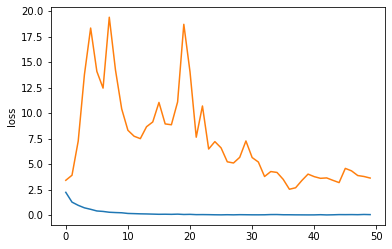

In [10]:
sns.lineplot(x=np.arange(50), y="loss", data=history.history)
sns.lineplot(x=np.arange(50), y="val_loss", data=history.history)

Calculate embedding and visualize results
-----------------------------------------

What we are actually interested in is the ResNet embedding values of the data after training. We expect that such an embedding contains relevant features of the image that can be used for downstream analysis such as clustering or integration with gene expression.

For generating this embedding, we first create a new dataset, that contains the full list of spots, in the correct order and without augmentation.

In [11]:
full_ds = create_dataset(
    adata, img, adata.obs_names.values, "cluster", augment=False, shuffle=False
)

Then, we instantiate another model without the output layer, in order to get the final embedding layer.

In [12]:
model_embed = tf.keras.Model(inputs, x)
embedding = model_embed.predict(full_ds)

We can then save the embedding in a new AnnData, and copy over all the relevant metadata from the AnnData with gene expression counts...

In [13]:
adata_resnet = AnnData(embedding, obs=adata.obs.copy())
adata_resnet.obsm["spatial"] = adata.obsm["spatial"].copy()
adata_resnet.uns = adata.uns.copy()
adata_resnet

AnnData object with n_obs × n_vars = 2688 × 2048
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'spatial'

... perform the standard clustering analysis.

In [14]:
sc.pp.scale(adata_resnet)
sc.pp.pca(adata_resnet)
sc.pp.neighbors(adata_resnet)
sc.tl.leiden(adata_resnet, key_added="resnet_embedding_cluster")
sc.tl.umap(adata_resnet)

Interestingly, it seems that despite the poor performance on the test set, the model has encoded some information relevant to separate spots from each other. The clustering annotation also resembles the original annotation based on gene expression similarity.

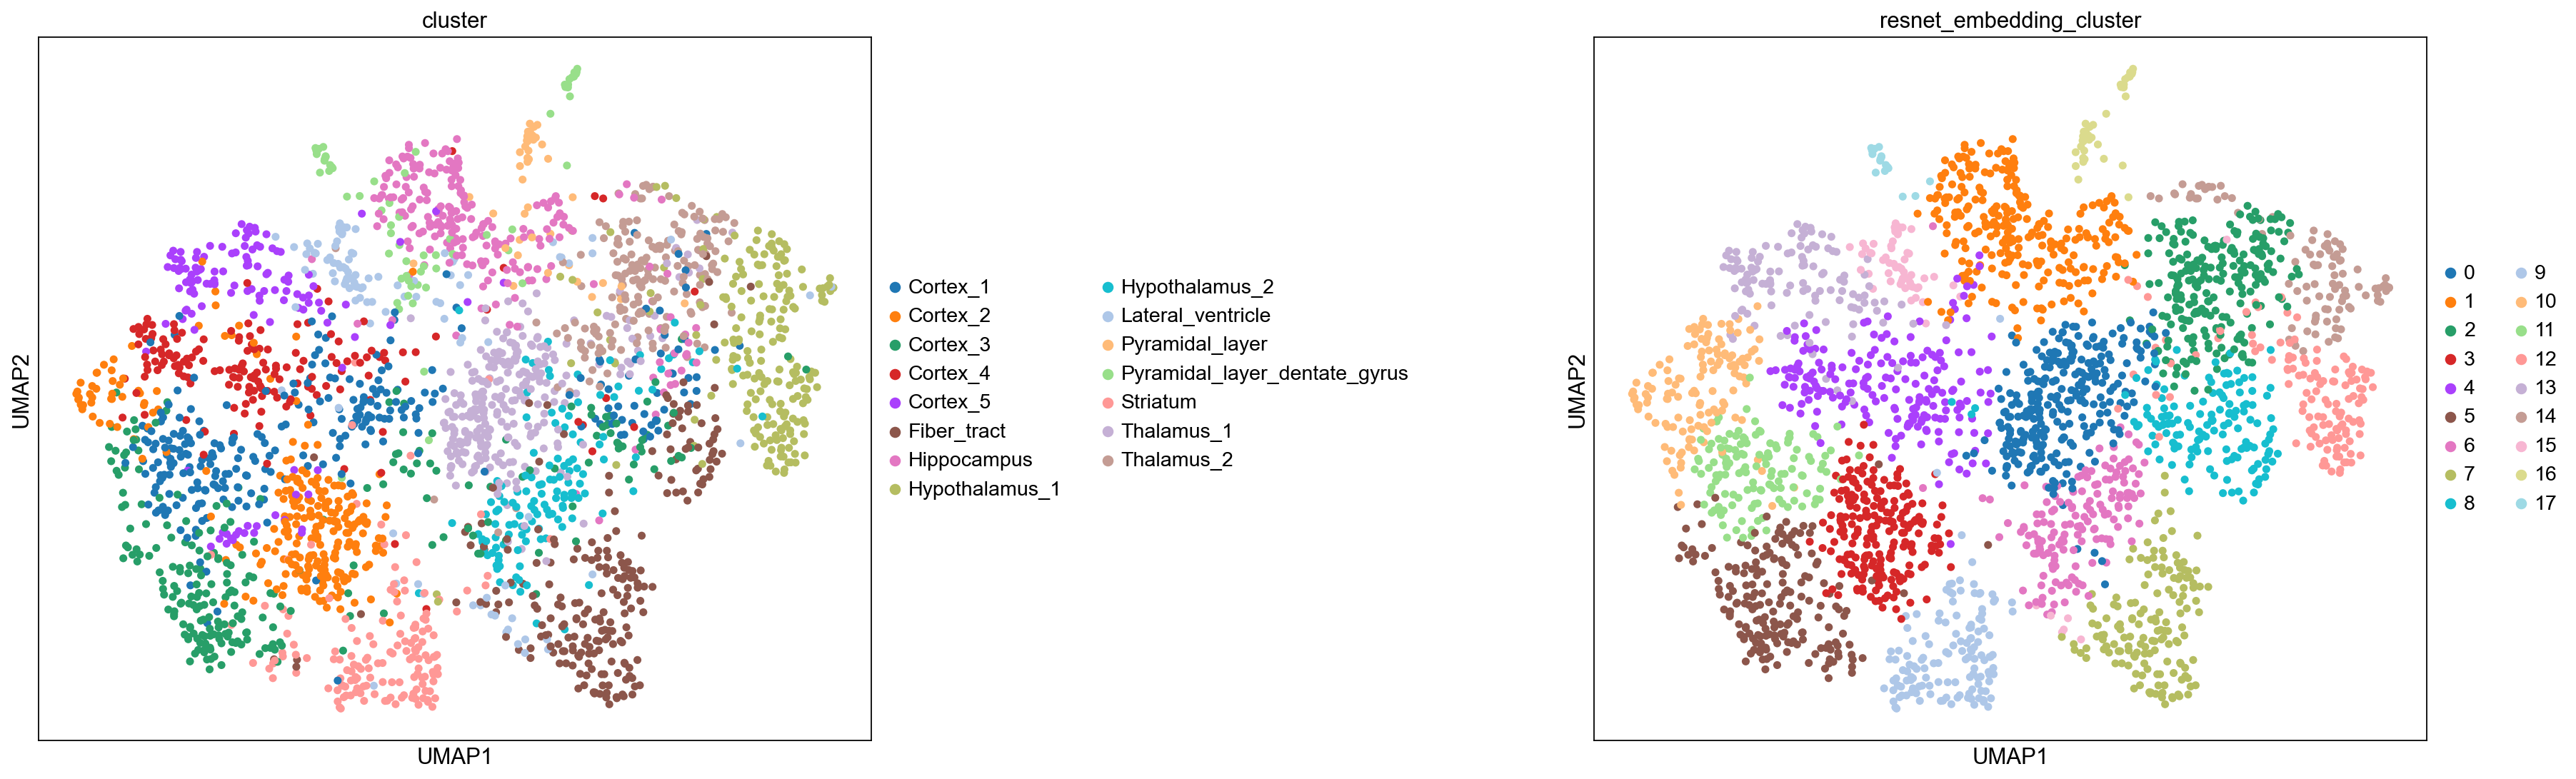

In [15]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.umap(
    adata_resnet, color=["cluster", "resnet_embedding_cluster"], size=100, wspace=0.7
)

We can visualize the same information in spatial coordinates. Again some clusters seems to closely recapitulate the Hippocampus and Pyramidal layers clusters. It seems to have worked surprisingly well!

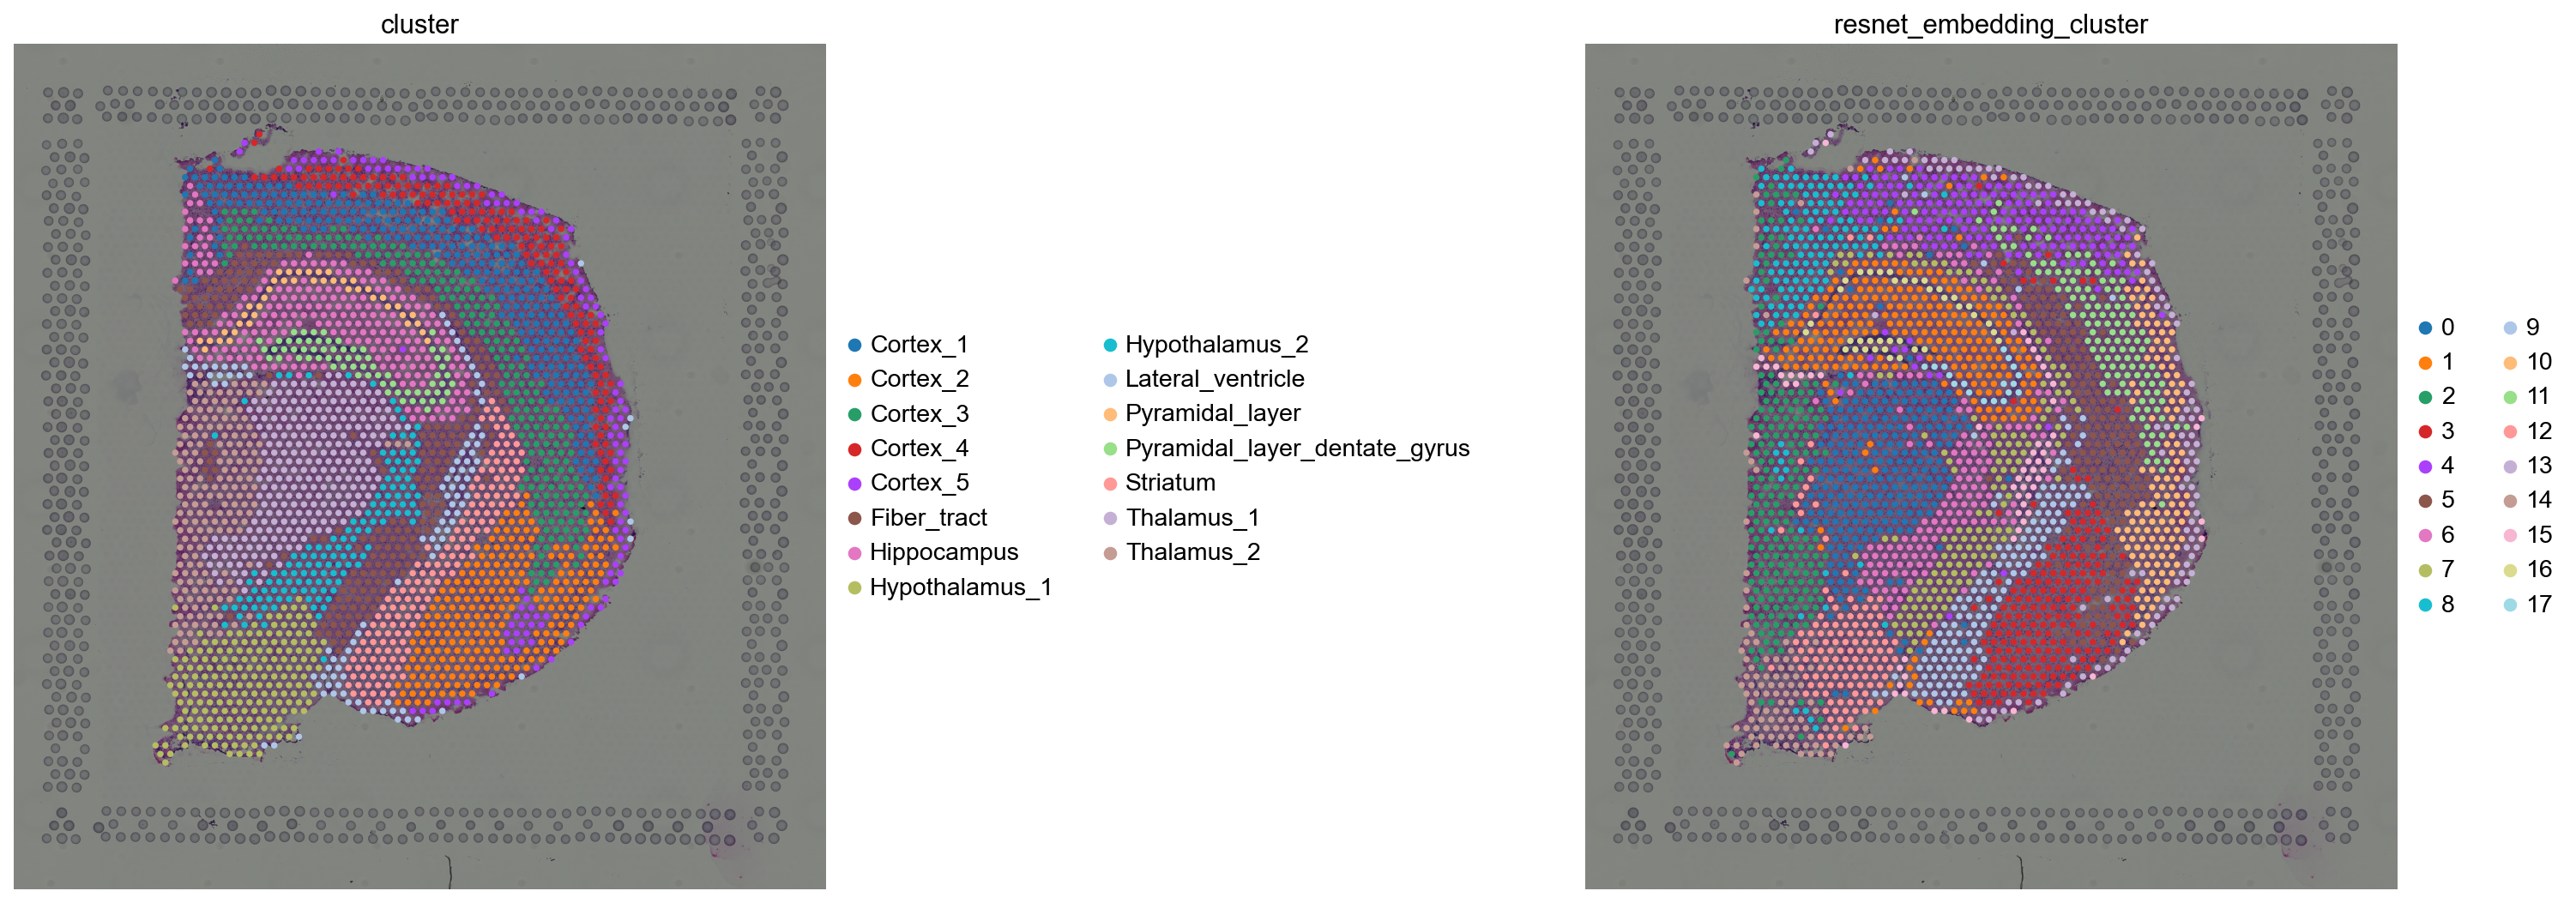

In [16]:
sq.pl.spatial_scatter(
    adata_resnet,
    color=["cluster", "resnet_embedding_cluster"],
    frameon=False,
    wspace=0.5,
)

An additional analysis could be to integrate information of both gene expression and the features learned by the ResNet classifier, in order to get a joint representation of both gene expression and image information. Such integration could be done for instance by concatenating the resulting PCA from the gene expression `adata` and the ResNet embedding `adata_resnet`. After concatenating the principal components, you could follow the usual steps of building a KNN graph and clustering with the leiden algorithm. 

With this tutorial we have shown how to interface the Squidpy workflow with modern deep learning frameworks, and have inspired you with additional analysis that leverage several data modalities and powerful DL-based representations.